# linear regression

The linear regression admit the following online learning relation given a new data instance $\boldsymbol{x}_i$:
\begin{align}
\boldsymbol{\Gamma}_{i}=&\boldsymbol{\Gamma}_{i-1}-\frac{\boldsymbol{\Gamma}_{i-1}\boldsymbol{x}_{i}\boldsymbol{x}_{i}^{T}\boldsymbol{\Gamma}_{i-1}}{1+\boldsymbol{x}_{i}^{T}\boldsymbol{\Gamma}_{i-1}\boldsymbol{x}_{i}}\\
\hat{\boldsymbol{\theta}}_{i}=&\hat{\boldsymbol{\theta}}_{i-1}-\boldsymbol{\Gamma}_{i}\boldsymbol{x}_{i}(\boldsymbol{x}_{i}^{T}\hat{\boldsymbol{\theta}}_{i-1}-y_{i})\\
iM_{i}=&(i-1)M_{i-1}+\frac{(\boldsymbol{x}_{i}^{T}\hat{\boldsymbol{\theta}}_{i-1}-y_{i})^{2}}{1+\boldsymbol{x}_{i}^{T}\boldsymbol{\Gamma}_{i-1}\boldsymbol{x}_{i}}
\end{align}

and the reverse relation when a instance $\boldsymbol{x}_i$ is removed instead:
\begin{align}
\boldsymbol{\Gamma}_{i-1}=&\boldsymbol{\Gamma}_{i}+\boldsymbol{\Gamma}_{i-1}\boldsymbol{x}_{i}\boldsymbol{x}_{i}^{T}\boldsymbol{\Gamma}_{i},
\end{align}
\begin{align}
\hat{\boldsymbol{\theta}}_{i-1}=&\hat{\boldsymbol{\theta}}_{i}+\boldsymbol{\Gamma}_{i-1}\boldsymbol{x}_{i}(\boldsymbol{x}_{i}^{T}\hat{\boldsymbol{\theta}}_{i}-y_{i}),
\end{align}
\begin{align}
(i-1)M_{i-1}=&iM_{i}-\frac{(\boldsymbol{x}_{i}^{T}\hat{\boldsymbol{\theta}}_{i}-y_{i})^{2}}{1-\boldsymbol{x}_{i}^{T}\boldsymbol{\Gamma}_{i}\boldsymbol{x}_{i}}.
\end{align}

### Code Online Linear Regression 
The code to realize the above discussion will be provided in the following: 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [101]:
X=tf.concat([tf.ones([1000,1]),tf.random.normal([1000,19])],axis=1)
theta=tf.range(1,21,1,dtype=tf.float32)
Y=tf.tensordot(X,theta,axes=[1,0])+tf.random.normal([1000])
Y=tf.expand_dims(Y,axis=1)

Next, we calculate the following stats. First we initialize the stats matrix by calculating the quantities for the sample composed of the first $d+1$ units with $d$ the feature dimensions. This is because the matrix $a$ is not reversible untill the sampel size is at least $d+1$.

In [102]:
def normalequation(X,Y,N):
    if N<X.shape[0]:
        a=tf.zeros([X.shape[1],X.shape[1]])
        b=tf.zeros([X.shape[1]])
        c=tf.zeros([1])
        for i in range(N):
            a+=tf.tensordot(tf.expand_dims(X[i],1),tf.expand_dims(X[i],1),axes=[1,1])
            b+=X[i]*Y[i]
            c+=Y[i]*Y[i]

        Gamma=tf.linalg.inv(a)
        # use normal equation to calculate theta
        theta_hat=tf.tensordot(Gamma,b,axes=[1,0])
        # use normal equation to calculate Mean Square Error
        M=(-tf.tensordot(tf.tensordot(b,Gamma,axes=[0,0]),b,axes=[0,0])+c)/N
    
        return [Gamma,theta_hat,M]
    else:
        raise ValueError('N exceeds sample size')

In [83]:
def RLS(X,Y):
    # stats=[up to current sample,[Gamma,theta,MSE]]
    stats=[[] for i in range(X.shape[0])]

    Gamma,theta_hat,M=normalequation(X,Y,X.shape[1])
    # initialize the first d elements by the 
    for i in range(X.shape[1]):
        stats[i].append(Gamma)
        stats[i].append(theta_hat)
        stats[i].append(M)


    for i in range(X.shape[1],X.shape[0]):
        # update Gamma matrix
        half=tf.tensordot(stats[i-1][0],X[i],axes=[1,0]) 
        numerator=tf.tensordot(tf.expand_dims(half,1),tf.expand_dims(half,1),axes=[1,1])
        denominator=(1+tf.tensordot(X[i],half,axes=[0,0]))
        Gammai=stats[i-1][0]-numerator/denominator
        stats[i].append(Gammai)

        misspred=tf.tensordot(stats[i-1][1],X[i],axes=[0,0])-Y[i]

        # update theta_hat   
        theta_hati=stats[i-1][1]-tf.tensordot(stats[i][0],X[i],axes=[1,0])*misspred
        stats[i].append(theta_hati)


        # update mean square error
        Mi=i/(i+1)*stats[i-1][2]+misspred*misspred/(denominator*(i+1))    
        stats[i].append(Mi)
        
    return stats

Next, we check whether the iterative method of rls is reasonable close to the result given by the normal equation.

In [121]:
def n_rls(start,end):
    fig,ax=plt.subplots(3)
    for j in range(3):
        m=[]
        for i in range(start,end):
            stat=normalequation(X,Y,20+i)  
            m.append(tf.reduce_max((stats[19+i][j]-stat[j])/(stat[j])))
            
        ax[j].plot(range(end-start),m)

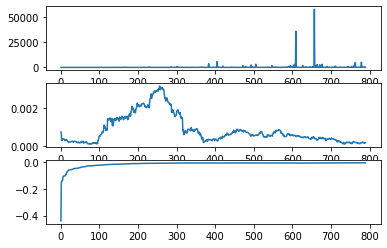

In [123]:
stats=RLS(X,Y)
n_rls(10,800)

We have built a linear regression class capable of RLS method [here](../../my_ml_lib/supervised_learning/linear_models.py).

In [ ]:
class linear_regression():
    def __init__(self,hparameter=None,stats=None):
        if hparameter is None:
            self.lambd=0
            self.sigma=0.05
        else:
            self.lambd=hparameter[0]
            self.sigma=hparameter[1]

        if stats is None:
            self.Gamma=None
            self.theta=None    
            self.loss=None
        else:           
            self.Gamma=stats[0]
            self.theta=stats[1]      
            self.loss=stats[2]


    
    def online_fit(self,X,Y,feature_i,feature_name_dtype=None):
        '''calculate stats for every binary division of the XY into XY[:i] and XY[i:] with i in range(len(XY))
           stats_up: store information about subsample XY[:i]
           stats_down: store information about subsample XY[i:]
        '''
        X_feature_i=X[:,feature_i]
     
        if not (feature_name_dtype is None):
            X=X[:,feature_name_dtype[:,1]=='c']

        N=len(Y)  
        d=X.shape[1]+1
        
        b_split_value=None    
        b_loss=np.Infinity  
        b_split_left_size=1
        b_split_right_size=N-1
        
        b_split_left_stats=None
        b_split_right_stats=None
               
        
        
        # initialize stats_up
        stats_up=[[] for i in range(len(Y))] 
        Gamma,theta_hat,M=self.partial_fit(X[:d],Y[:d])
        # initialize the first d elements by the 
        for i in range(d):
            stats_up[i].append(Gamma)
            stats_up[i].append(theta_hat)
            stats_up[i].append(M)                        # value of loss

       
        # initialize stats_down
        if self.theta is None:
            self.fit(X[d:],Y[d:])
            
        stats_down=[[] for i in range(len(Y))]
        for i in range(d):
            stats_down[i].append(self.Gamma)
            stats_down[i].append(self.theta)
            stats_down[i].append(self.loss)

        
        X=np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        
        for i in range(d,X.shape[0]-d):         
        #updata stats_up
            # update Gamma matrix

            half=np.tensordot(stats_up[i-1][0],X[i],axes=[1,0]) 
            numerator=np.tensordot(np.expand_dims(half,1),np.expand_dims(half,1),axes=[1,1])
            
            denominator=(1+np.tensordot(X[i],half,axes=[0,0]))          
            Gammai=stats_up[i-1][0]-numerator/denominator
            stats_up[i].append(Gammai)

            misspred=np.tensordot(stats_up[i-1][1],X[i],axes=[0,0])-Y[i]

            # update theta_hat   
            theta_hati=stats_up[i-1][1]-np.tensordot(stats_up[i][0],X[i],axes=[1,0])*misspred
            stats_up[i].append(theta_hati)


            # update mean square error
            Mi=i/(i+1)*stats_up[i-1][2]+misspred*misspred/(denominator*(i+1))    
            stats_up[i].append(Mi)
            
         #updata stats_down   
            # update Gamma matrix
            half=np.tensordot(stats_down[i-1][0],X[i-1],axes=[1,0]) 
            numerator=np.tensordot(np.expand_dims(half,1),np.expand_dims(half,1),axes=[1,1])
            denominator=(1-np.tensordot(X[i-1],half,axes=[0,0]))
            Gammai=stats_down[i-1][0]+numerator/denominator
            stats_down[i].append(Gammai)

            misspred=np.tensordot(stats_down[i-1][1],X[i-1],axes=[0,0])-Y[i-1]

            # update theta_hat   
            theta_hati=stats_down[i-1][1]+np.tensordot(stats_down[i][0],X[i-1],axes=[1,0])*misspred
            stats_down[i].append(theta_hati)


            # update mean square error
            Mi=(N-(i-1))/(N-i)*stats_down[i-1][2]-misspred*misspred/(denominator*(N-i))    
            stats_down[i].append(Mi)
            
        # find out the best split point
            if  X_feature_i[i]!=X_feature_i[i-1] or i==len(Y):
                if stats_up[i-1][-1]*i/N+stats_down[i][-1]*(N-i)/N<b_loss:
                    b_split_left_stats=stats_up[i-1]
                    b_split_right_stats=stats_down[i]
                    b_split_left_size=i
                    b_split_right_size=N-i
                    
                    b_loss=stats_up[i-1][-1]*i/N+stats_down[i][-1]*(N-i)/N
                    b_split_value=X_feature_i[i-1]
                   
        return b_split_left_stats,b_split_right_stats,b_split_left_size,b_split_right_size,b_split_value,b_loss
        #return stats_up,stats_down
    
    def batch_fit(self,X,Y,feature_i,feature_name_dtype=None):
        '''calculate stats for every binary division of the XY into XY[:,feature_i]==value and XY[:,feature_i]!=value 
           for all possible values of feature_i
           omega_batch,loss_batch: information about subsample XY[:,feature_i]==value
           omega_ba_null,loss_ba_null: information about subsample XY[:,feature_i]!=value 
        '''
        X_feature_i=X[:,feature_i]
        
        if not (feature_name_dtype is None):
            X=X[:,feature_name_dtype[:,1]=='c']                 
       
        N=len(Y)
               
        d=X.shape[1]+1
        
        b_split_left_stats=None
        b_split_right_stats=None
        b_split_left_size=1
        b_split_right_size=N-1
        
        best_split_value=None
        best_loss=np.Infinity
        
        # initialize stats_down

        if self.theta is None:
            self.fit(X[d:],Y[d:])

        
        X=np.concatenate((X,np.ones((X.shape[0],1))),axis=1)

        stats_batch=[]
        stats_ba_null=[]
        
        #l,r: left bound and right bound of the batch
        l=0
        r=1
        while r<len(Y):
            while r<len(X) and X_feature_i[r]==X_feature_i[r-1]:
                r+=1
                
            stats_batch=self.partial_fit(X[l:r],Y[l:r])
            stats_ba_null=self.partial_fit(np.concatenate(X[:l],X[r:],axis=0),np.concatenate(Y[:l],Y[r:],axis=0))
                   
            if stats_batch[-1]*(r-l)/N+stats_ba_null[-1]*(N-(r-l))/N<best_loss:
                b_split_left_stats=stats_batch
                b_split_right_stats=stats_ba_null
                b_split_left_size=r-l
                b_split_right_size=N-(r-l)
                
                best_loss=stats_batch[-1]*(r-l)/N+stats_ba_null[-1]*(N-(r-l))/N
                best_split_value=X_feature_i[r-1]               
            
            l=r
            r+=1
            
        return b_split_left_stats,b_split_right_stats,b_split_left_size,b_split_right_size,best_split_value,best_loss
            
                  
    def partial_fit(self,X,Y,feature_name_dtype=None): 
        if not (feature_name_dtype is None):
            X=np.concatenate((X[:,feature_name_dtype[:,1]=='c'],np.ones((X.shape[0],1))),axis=1)
        else:
            X=np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
            
        N=len(Y)    
        a=np.zeros([X.shape[1],X.shape[1]])
        b=np.zeros([X.shape[1]])
        c=np.zeros([1])
        for i in range(N):
            a+=np.tensordot(np.expand_dims(X[i],1),np.expand_dims(X[i],1),axes=[1,1])
            b+=X[i]*Y[i]
            c+=Y[i]*Y[i]

        Gamma=np.linalg.inv(a+self.sigma*np.identity(X.shape[1]))
        # use normal equation to calculate theta
        theta_hat=np.tensordot(Gamma,b,axes=[1,0])
        # use normal equation to calculate Mean Square Error
        M=(-np.tensordot(np.tensordot(b,Gamma,axes=[0,0]),b,axes=[0,0])+c)/N
 
        return [Gamma,theta_hat,M]
    
    def fit(self,X,Y,feature_name_dtype=None):    
        if not (feature_name_dtype is None):
            X=np.concatenate((X[:,feature_name_dtype[:,1]=='c'],np.ones((X.shape[0],1))),axis=1)
        else:
            X=np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
            
        a=np.zeros([X.shape[1],X.shape[1]])
        b=np.zeros([X.shape[1]])
        c=np.zeros([1])
        for i in range(X.shape[0]):
            a+=np.tensordot(np.expand_dims(X[i],1),np.expand_dims(X[i],1),axes=[1,1])
            b+=X[i]*Y[i]
            c+=Y[i]*Y[i]

        Gamma=np.linalg.inv(a+self.sigma*np.identity(X.shape[1]))
        # use normal equation to calculate theta
        theta_hat=np.tensordot(Gamma,b,axes=[1,0])
        # use normal equation to calculate Mean Square Error
        M=(-np.tensordot(np.tensordot(b,Gamma,axes=[0,0]),b,axes=[0,0])+c)/X.shape[0]
        
        self.Gamma=Gamma
        self.theta=theta_hat
        self.loss=M

    
    
    def predict(self,X,feature_name_dtype=None):
          
        if len(np.shape(X))==2:
            if not (feature_name_dtype is None):
                X=np.concatenate((X[:,feature_name_dtype[:,1]=='c'],np.ones((X.shape[0],1))),axis=1)
            else:
                X=np.concatenate((X,np.ones((X.shape[0],1))),axis=1)

            return np.tensordot(self.theta,X,axes=[0,1])   
        
        elif len(np.shape(X))==1:
            if not (feature_name_dtype is None):
                X=np.concatenate((X[feature_name_dtype[:,1]=='c'],[1]),axis=0)
            else:
                X=np.concatenate((X,[1]),axis=0)               
            return np.array([np.tensordot(self.theta,X,axes=[0,0])])
        else:
            raise ValueError('The shape of input data is incorrect')
    def model_description(self):
        model_eq='y='
        for i in range(len(self.theta)-1):
            model_eq+='+{}*X_{}'.format(round(self.theta[i],5),i) if self.theta[i]>=0 \
                      else '{}*X_{}'.format(round(self.theta[i]),i)
        model_eq+='{}'.format(self.theta[-1])
        return model_eq

In [6]:
class average_regression():
    def __init__(self,hparameter=0,stats=None):
        self.lambd=hparameter
        if stats is None:
            self.parameter=0     
            self.loss=0
        else:
            self.parameter=stats[0]      
            self.loss=stats[1]
            


    
    def online_fit(self,X,Y,feature_i,feature_name_dtype=None):
        '''calculate stats for every binary division of the XY into XY[:i] and XY[i:] with i in range(len(XY))
           stats_up: store information about subsample XY[:i]
           stats_down: store information about subsample XY[i:]
        '''
        ## quantites record information about the best split
        N=len(Y)
        
        b_split_value=None    
        b_loss=np.Infinity  
        b_split_left_size=1
        b_split_right_size=N-1
        
        b_split_left_stats=None
        b_split_right_stats=None
               
        
        
        # initialize stats_up
        stats_up=[[] for i in range(len(Y))] 
        stats_up[0].append(self.partial_fit(X[0:1],Y[0:1]))                       # value of omega
        stats_up[0].append(self.loss_cal(X[0:1],Y[0:1]))                          # value of loss

       
        # initialize stats_down
        if not self.parameter:
            self.fit(X,Y)
        if not self.loss:
            self.loss=self.loss_cal(X,Y)

        stats_down=[[] for i in range(len(Y))]
        stats_down[0].append(self.parameter)
        stats_down[0].append(self.loss)
        
        
        for i in range(1,len(Y)):
            
            # update stats_up
            omega_i=stats_up[i-1][0]*i/(i+1)+Y[i,0]/(1+self.lambd)/(i+1)
            loss_i=((stats_up[i-1][1]+(1+self.lambd)*stats_up[i-1][0]**2)*i/(i+1)+Y[i,0]**2/(i+1))\
                   -(1+self.lambd)*(omega_i**2)
            stats_up[i].append(omega_i)
            stats_up[i].append(loss_i)


            # update stats_down
            omega_i_1=stats_down[i-1][0]*(N-i+1)/(N-i)-Y[i-1,0]/(1+self.lambd)/(N-i)
            loss_i_1=((stats_down[i-1][1]+(1+self.lambd)*stats_down[i-1][0]**2)*(N-i+1)/(N-i)-Y[i-1,0]**2/(N-i))\
                   -(1+self.lambd)*(omega_i_1**2)
            stats_down[i].append(omega_i_1)
            stats_down[i].append(loss_i_1)
            
            # find out the best split point
            if X[i,feature_i]!=X[i-1,feature_i] or i==len(Y):
                if stats_up[i-1][-1]*i/N+stats_down[i][-1]*(N-i)/N<b_loss:
                    b_split_left_stats=stats_up[i-1]
                    b_split_right_stats=stats_down[i]
                    b_split_left_size=i
                    b_split_right_size=N-i
                    
                    b_loss=stats_up[i-1][-1]*i/N+stats_down[i][-1]*(N-i)/N
                    b_split_value=X[i-1,feature_i]
                   
        return b_split_left_stats,b_split_right_stats,b_split_left_size,b_split_right_size,b_split_value,b_loss
    
    def batch_fit(self,X,Y,feature_i,feature_name_dtype=None):
        '''calculate stats for every binary division of the XY into XY[:,feature_i]==value and XY[:,feature_i]!=value 
           for all possible values of feature_i
           omega_batch,loss_batch: information about subsample XY[:,feature_i]==value
           omega_ba_null,loss_ba_null: information about subsample XY[:,feature_i]!=value 
        '''
        N=len(Y)
        
        b_split_left_stats=None
        b_split_right_stats=None
        b_split_left_size=1
        b_split_right_size=N-1
        
        best_split_value=None
        best_loss=np.Infinity
        
        # initialize stats_down
        if not self.parameter:
            self.fit(X,Y)
        if not self.loss:
            self.loss=self.loss_cal(X,Y)
            
        omega_tot=self.parameter
        loss_tot=self.loss
        
        
        
        #l,r: left bound and right bound of the batch
        l=0
        r=1
        while r<len(Y):
            while r<len(X) and X[r,feature_i]==X[r-1,feature_i]:
                r+=1
                
            omega_batch=self.partial_fit(X[l:r],Y[l:r])
            loss_batch=self.loss_cal(X[l:r],Y[l:r])
                       
            omega_ba_null=omega_tot*N/(N-(r-l))-np.sum(Y[l:r])/(1+self.lambd)/(N-(r-l))
            loss_ba_null=((loss_tot+(1+self.lambd)*omega_tot**2)*N/(N-(r-l))-np.sum(Y[l:r]**2)/(N-(r-l)))\
                   -(1+self.lambd)*(omega_ba_null**2)
            
            
            if loss_batch*(r-l)/N+loss_ba_null*(N-(r-l))/N<best_loss:
                b_split_left_stats=[omega_batch,loss_batch]
                b_split_right_stats=[omega_ba_null,loss_ba_null]
                b_split_left_size=r-l
                b_split_right_size=N-(r-l)
                
                best_loss=loss_batch*(r-l)/N+loss_ba_null*(N-(r-l))/N
                best_split_value=X[r-1,feature_i]               
            
            l=r
            r+=1
            
        return b_split_left_stats,b_split_right_stats,b_split_left_size,b_split_right_size,best_split_value,best_loss
            
                  
    def partial_fit(self,X,Y,feature_name_dtype=None):
        # conventional stochastic gradient method to train model
        return np.mean(Y)/(1+self.lambd)
    
    def fit(self,X,Y,feature_name_dtype=None):
        # conventional stochastic gradient method to train model
        self.parameter=np.mean(Y)/(1+self.lambd)
    
    def predict(self,X,feature_name_dtype=None):
        if len(np.shape(X))==2:
            return np.array([self.parameter for i in range(X.shape[0])])        
        elif len(np.shape(X))==1:
            return np.array([self.parameter])
        else:
            raise ValueError('The shape of input data is incorrect')
    
    def loss_cal(self,X,Y,feature_name_dtype=None):
        return np.mean(Y**2)-np.mean(Y)**2/(1+self.lambd)
    
    def model_description(self):
        return 'predicted value is {}'.format(self.parameter)